In [4]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import ipywidgets as widgets
import pickle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import cm

import ReservoirComputer3_2 as ReCom
import ReservoirGrid_2 as ReGrid

In [5]:
def lorenz(u, t, *args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = alpha[0], alpha[1], alpha[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])

T_train = 100
T_predict = 150
dt = 0.01
alpha = (8.0/3.0, 28.0, 10.0)
x0 = np.asarray([1.0, 1.0, 1.0])
t_points_training = np.linspace(0, T_train, int(T_train/dt))
t_points_predict = np.linspace(0, T_predict, int(T_predict/dt))
train_data = integrate.odeint(lorenz, x0, t_points_training, args=alpha)
val_data = integrate.odeint(lorenz, train_data[-1], t_points_predict, args=alpha)

In [6]:
rho_list = np.arange(0.1, 1.0, 0.1)
sigma_list = np.arange(0.1, 1.0, 0.1)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))

In [7]:
RC = ReCom.ESN(N=100, p=0.01, d=3, rho=0, sigma=0, gamma=10.0, beta=1e-6)
esn_rs_grid = ReGrid.Comb_ESN_RhoSigmaGrid(rho_list, sigma_list, RC)

In [9]:
%%time
esn_rs_grid.train_RCs(train_data, t_points_training, t_listen=5000)

Wall time: 1min 46s


In [6]:
rho_sigma_RCs = esn_rs_grid.rho_sigma_RCs

In [10]:
%store -r rho_sigma_RCs

no stored variable or alias rho_sigma_RCs


In [11]:
%%time
esn_rs_grid.calc_trajectories(t_points_predict, ics)

0.1 0.1
0.1 0.2
0.1 0.30000000000000004
0.1 0.4
0.1 0.5
0.1 0.6
0.1 0.7000000000000001
0.1 0.8
0.1 0.9
0.2 0.1
0.2 0.2
0.2 0.30000000000000004
0.2 0.4
0.2 0.5
0.2 0.6
0.2 0.7000000000000001
0.2 0.8
0.2 0.9
0.30000000000000004 0.1
0.30000000000000004 0.2
0.30000000000000004 0.30000000000000004
0.30000000000000004 0.4
0.30000000000000004 0.5
0.30000000000000004 0.6
0.30000000000000004 0.7000000000000001
0.30000000000000004 0.8
0.30000000000000004 0.9
0.4 0.1
0.4 0.2
0.4 0.30000000000000004
0.4 0.4
0.4 0.5
0.4 0.6
0.4 0.7000000000000001
0.4 0.8
0.4 0.9
0.5 0.1
0.5 0.2
0.5 0.30000000000000004
0.5 0.4
0.5 0.5
0.5 0.6
0.5 0.7000000000000001
0.5 0.8
0.5 0.9
0.6 0.1
0.6 0.2
0.6 0.30000000000000004
0.6 0.4
0.6 0.5
0.6 0.6
0.6 0.7000000000000001
0.6 0.8
0.6 0.9
0.7000000000000001 0.1
0.7000000000000001 0.2
0.7000000000000001 0.30000000000000004
0.7000000000000001 0.4
0.7000000000000001 0.5
0.7000000000000001 0.6
0.7000000000000001 0.7000000000000001
0.7000000000000001 0.8
0.7000000000000001 0.9


In [9]:
%matplotlib inline
@widgets.interact(i=(0, rho_list.size-1, 1), j=(0, sigma_list.size-1, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=0, t_start=1000, t_end=15000, xlim=200, ylim=200, zlim=200):
    fig = plt.figure(figsize=(15,9))  
    ReGrid.plot_traj(esn_rs_grid.trajectories[i,j], t_start, t_end, xlim, ylim, zlim)
    print(rho_list[i], sigma_list[j])

interactive(children=(IntSlider(value=0, description='i', max=8), IntSlider(value=0, description='j', max=8), …

In [10]:
%%time
esn_rs_grid.attractor_dict(0.01, lorenz, alpha)

Wall time: 15 s


In [11]:
%%time
attractor_encoding = { 
    (0, 0, 0):0, (1, 0, 0):1, (2, 0, 0):2, (5, 0, 0):3,
    (0, 1, 0):4, (1, 1, 0):5, (2, 1, 0):6, (2, 1, 1):7,
    (1, 0, 1):8, (2, 0, 1):9, (1, 1, 1):10, (3, 1, 1):11,
    (0, 1, 1):12, (0, 0, 1):13
}
ua_mat = esn_rs_grid.ua_matrix(attractor_encoding) 

Wall time: 0 ns


In [12]:
rev_encoding = {v: k for k, v in attractor_encoding.items()}

In [13]:
valid_vals = list(set(ua_mat.flatten()))
valid_vals.sort()
indices = list(range(len(valid_vals)))
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [14]:
def tuple_to_label(x):
    if max(x) == 0 and min(x) == 0:
        label = "No UAs"
    else:
        label = []
        if x[0] != 0:
            label.append(str(x[0]) + " FP, ")
        if x[1] != 0:
            label.append(str(x[1]) + " LC, ")
        if x[2] != 0:
            label.append(str(x[2]) + " other ")
        label = "".join(label)
    if label[-2:] ==', ':
        label = label[:-2]
    return label


def rank_matrix(mat):
    rank_mat = np.zeros(mat.shape)
    rank_list = list(set(mat.flatten()))
    rank_list.sort()
    for i in range(rank_mat.shape[0]):
        # get the index of the element in the rank list
        rank_mat[i] = [np.where(rank_list==x)[0][0] for x in mat[i]]
    
    return rank_mat


def index_matrix(mat):
    index_mat = np.zeros(mat.shape)
    index_list = list(set(mat.flatten()))
    index_list.sort()
    for i in range(rank_mat.shape[0]):
        # get the index of the element in the rank list
        index_mat[i] = [np.where(rank_list==x)[0][0] for x in mat[i]]
    
    return rank_mat

In [36]:
ua_mat

array([[ 4.,  4.,  1.,  4.,  4.,  4.,  4.,  1.,  1.],
       [ 4.,  4.,  4.,  4.,  4.,  4., 12.,  4., 10.],
       [ 4.,  4.,  4.,  4.,  4.,  5.,  4.,  4.,  5.],
       [ 4.,  4.,  4.,  4.,  4.,  4., 10.,  4.,  5.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  4.],
       [12.,  4.,  4.,  4.,  8.,  5.,  5.,  5.,  5.],
       [ 4.,  4.,  4., 13.,  2.,  8.,  5.,  5.,  5.],
       [ 4.,  4.,  4., 12.,  5.,  9.,  8., 10.,  6.],
       [ 4.,  1.,  4.,  9., 13., 13.,  8.,  4.,  6.]])

Text(0.5, 1.0, 'Untrained attractors in predicting reservoir state space')

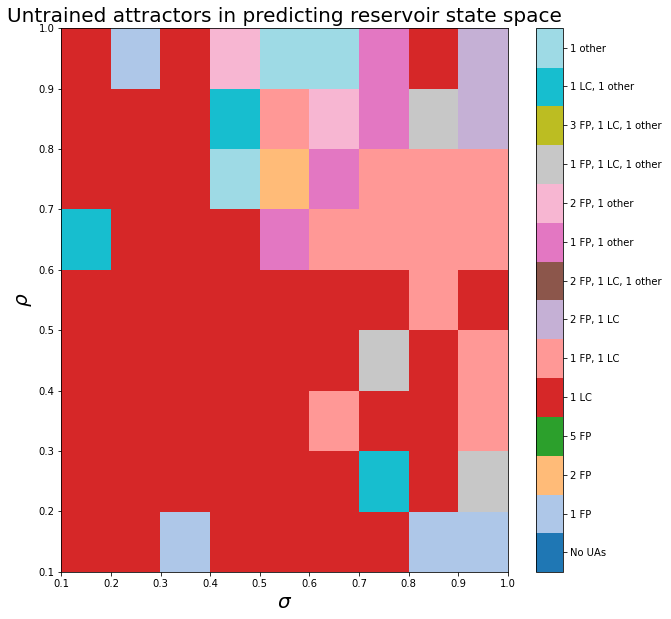

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(ua_mat,
           origin='lower', extent=[0.1, 1.0, 0.1, 1.0], 
           aspect='auto',
           cmap=plt.cm.get_cmap('tab20', 14))

formatter = plt.FuncFormatter(lambda val, loc: tuple_to_label(rev_encoding[val]))

# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], format=formatter);

# Set the clim so that labels are centered on each block
plt.clim(-0.5, 13.5)

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.xlabel(r'$\sigma$', fontsize=20)
plt.ylabel(r'$\rho$', fontsize=20)
plt.title("Untrained attractors in predicting reservoir state space", fontsize=20)

In [31]:
ua_mat

array([[ 4.,  4.,  1.,  4.,  4.,  4.,  4.,  1.,  1.],
       [ 4.,  4.,  4.,  4.,  4.,  4., 12.,  4., 10.],
       [ 4.,  4.,  4.,  4.,  4.,  5.,  4.,  4.,  5.],
       [ 4.,  4.,  4.,  4.,  4.,  4., 10.,  4.,  5.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  4.],
       [12.,  4.,  4.,  4.,  8.,  5.,  5.,  5.,  5.],
       [ 4.,  4.,  4., 13.,  2.,  8.,  5.,  5.,  5.],
       [ 4.,  4.,  4., 12.,  5.,  9.,  8., 10.,  6.],
       [ 4.,  1.,  4.,  9., 13., 13.,  8.,  4.,  6.]])

In [29]:
np.savetxt("ESN_attractors.csv", ua_mat, delimiter=",")

In [18]:
%%time
tpe_matrix = esn_rs_grid.pred_tpe_mat(0.01, lorenz, alpha)

Wall time: 21.9 s


In [19]:
log_tpe_matrix = np.log(tpe_matrix)

Text(0.5, 1.0, 'Prediction log TPE')

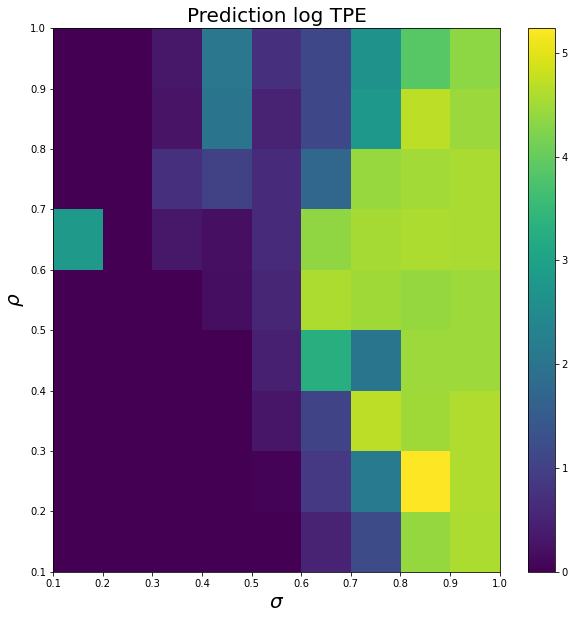

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(log_tpe_matrix,
               origin='lower', extent=[0.1, 1.0, 0.1, 1.0],
               vmax=log_tpe_matrix.max(), vmin=0,
               aspect='auto',
               cmap=plt.cm.get_cmap('viridis'))

plt.colorbar();

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.xlabel(r'$\sigma$', fontsize=20)
plt.ylabel(r'$\rho$', fontsize=20)
plt.title("Prediction log TPE", fontsize=20)

In [33]:
np.savetxt("ESN_log_TPE.csv", log_tpe_matrix, delimiter=",")

In [21]:
%%time
rp_matrix = esn_rs_grid.rp_matrix(0.01, lorenz, alpha, 5)

Wall time: 7min 46s


In [22]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

Text(0.5, 1.0, 'Proportion of ICs on Embedded Lorenz')

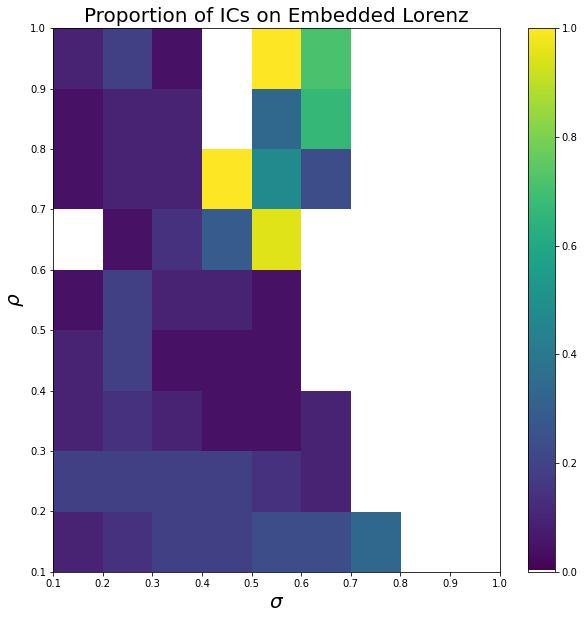

In [23]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([256/256, 256/256, 256/256, 1])
newcolors[0, :] = white
newcmp = ListedColormap(newcolors)

fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(rp_matrix,
               origin='lower', extent=[0.1, 1.0, 0.1, 1.0],
               vmax=1, vmin=0,
               aspect='auto',
               cmap=newcmp)

plt.colorbar();

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.xlabel(r'$\sigma$', fontsize=20)
plt.ylabel(r'$\rho$', fontsize=20)
plt.title("Proportion of ICs on Embedded Lorenz", fontsize=20)

In [35]:
np.savetxt("ESN_rp.csv", rp_matrix, delimiter=",")